In [1]:
import pandas as pd 
import numpy as np
import datetime as dt
from pandas.tseries.offsets import MonthEnd, Day, Week
import matplotlib.pyplot as plt
import quantstats as qs
import warnings
import seaborn as sns
import scipy.stats
import statsmodels.api as sm
from tabulate import tabulate
warnings.filterwarnings("ignore")

/Users/guilhermedias/opt/anaconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


#### Importing the data

In [2]:
prices = pd.read_csv('prices.csv', engine = 'pyarrow')
prices.index = prices.iloc[:,0]
prices.index = pd.to_datetime(prices.index)
prices = prices.iloc[:,1:]
prices = prices.astype(float)

In [3]:
ineg = pd.read_csv('Ineg.csv', engine = 'pyarrow')
ineg.index = ineg.iloc[:,0]
ineg.index = pd.to_datetime(ineg.index)
ineg = ineg.iloc[:,1:]
ineg = ineg.astype(float)

In [4]:
p_vpa = pd.read_csv("p_vpa.csv", engine = "pyarrow")
p_vpa.index = p_vpa.iloc[:,0]
p_vpa.index = pd.to_datetime(p_vpa.index)
p_vpa = p_vpa.iloc[1:,1:]
p_vpa = p_vpa.astype(float)

In [5]:
ev_ebitda = pd.read_csv('Ev_ebitda.csv', index_col = 'Data', engine = 'pyarrow')
ev_ebitda.index = pd.to_datetime(ev_ebitda.index)
ev_ebitda = ev_ebitda.astype(float)

#### Defining and automatization of the model

In [6]:
class Strategy:
    """
    Funcion created to calculate
    the strategy profit for a quality
    and value intersection and posterior
    momentum filter. Retrieving the strategy profit.
   

   
    Parameters
    ----------

    Prices: `pd.Series or pd.DataFrame` --> Series of historical prices data for the stocks

    Ineg: `pd.Series or pd.DataFrame` --> Series of the negotiability index data for the stocks

    Pb: `pd.Series or pd.DataFrame` --> Series of Price / Book data for the stocks

    Ebitda: `pd.Series or pd.DataFrame` --> Series of Entreprise Value / Ebitda data for the stocks
    
    Initial_data: `DateTime` -->  The initial date for the strategy
    
    Final_data: `DateTime` -->  The final date for the strategy

    """

    def __init__(self, prices, ineg, pb, ebitda, initial_data = '2000-02-28', final_data = '2021-12-31', momentum_size:float = .3, quality_size: float = .5, position: str = 'long-only', momentum_lookback:float = 11):

        self.normal_frame = None
        self.final_frame = None
        self.type_freq = None
        self.tipo = None
        if not isinstance(prices, (pd.Series, pd.DataFrame, np.ndarray)):
            raise ValueError("Prices must be a Pandas DataFrame, Pandas Series or Numpy Array")

        if not isinstance(ineg, (pd.Series, pd.DataFrame, np.ndarray)):
            raise ValueError("Ineg must be a Pandas DataFrame, Pandas Series or Numpy Array")

        if not isinstance(pb, (pd.Series, pd.DataFrame, np.ndarray)):
            raise ValueError("Price to Book must be a Pandas DataFrame, Pandas Series or Numpy Array")

        if not isinstance(ebitda, (pd.Series, pd.DataFrame, np.ndarray)):
            raise ValueError("Entreprise Value / Ebitda must be a Pandas DataFrame, Pandas Series or Numpy Array")

        if not isinstance(initial_data, dt.datetime):
            raise ValueError("Initial Data for the analysis must be a Datetime.datetime")

        if not isinstance(final_data, dt.datetime):
            raise ValueError("Final Data must be a Datetime.datetime")

        if not isinstance(momentum_size, (int, float)):
            raise ValueError("The decile of momentum decile that gonna be taken must be a interger or float number")

        if not isinstance(quality_size, (int, float)):
            raise ValueError("The decile of Quality / Value intersection decile that gonna be taken must be a interger or float number")

        self.initial_data = pd.to_datetime(initial_data) - MonthEnd(1)
        self.final_data = pd.to_datetime(final_data) + MonthEnd(1)
        self.ineg_mtl = (ineg.resample("1M").last()).loc[self.initial_data : self.final_data]
        self.vpa_mtl = (pb.resample("1M").last()).loc[self.initial_data : self.final_data]
        self.ebitda_mtl = (ebitda.resample("1M").last()).loc[self.initial_data : self.final_data]

        self.past_11 = (prices.resample("M").last()/ prices.resample("M").first().shift(momentum_lookback) - 1)
        self.daily_prices = ((prices / prices.shift(1)) - 1).loc[self.initial_data : self.final_data]
        self.returns = ((prices.resample("M").last() / prices.resample("M").last().shift(1)) - 1).loc[self.initial_data : self.final_data] 
        
        self.past_11 = (prices.resample("M").last()/ prices.resample("M").last().shift(momentum_lookback) - 1)
        self.momentum = momentum_size
        self.quality = quality_size
        self.position = position.lower()

    def __filtro__(self, formation):  


        if not isinstance(formation, dt.datetime):
            raise ValueError("Formation data for the analysis must be a Datetime.datetime")
        
        end_measurement = formation - self.tipo
        universo = self.ineg_mtl.loc[end_measurement].sort_values(ascending = False).head(100).index.to_list()
        filtro_pb = self.vpa_mtl.loc[end_measurement, self.vpa_mtl.columns.isin(universo)]
        filtro_ev_ebitda = self.ebitda_mtl.loc[end_measurement, self.ebitda_mtl.columns.isin(universo)]
        filtro_ev_ebitda = filtro_ev_ebitda[filtro_ev_ebitda >= 0]
        filtro_both = pd.DataFrame({'P Vpa': filtro_pb, 'Ev Ebitda': filtro_ev_ebitda})
        filtro_both = filtro_both.replace(np.nan, '0').astype(float)
        filtro_both['PVpa filtrados'] = pd.qcut(filtro_both['P Vpa'], q = 100, labels = False, duplicates = 'drop')
        filtro_both['Ev Ebitda filtrados'] = pd.qcut(filtro_both['Ev Ebitda'], q = 100, labels = False, duplicates = 'drop')
        filtro_both = filtro_both.replace(np.nan, 0).astype(float)
        filtro_both['Filtro Final'] = filtro_both['PVpa filtrados'] + filtro_both['Ev Ebitda filtrados'] 
        filtro_both = filtro_both.replace(0, np.nan)
        filtro_both['Filtro Final'] = filtro_both['Filtro Final'].dropna()
        final_filter = filtro_both['Filtro Final'].dropna().sort_values(ascending = False)

        pb_ebitda_winners = final_filter.tail(int(self.quality * len(universo))).index.to_list()
        ret_12_winners = self.past_11.loc[end_measurement,self.past_11.columns.isin(pb_ebitda_winners)]
        self.winners = ret_12_winners.sort_values(ascending = False).head(int(self.momentum*len(pb_ebitda_winners))).reset_index()['index'].to_list()
        winners_mtl_ret = self.returns.loc[formation +self.tipo, self.returns.columns.isin(self.winners)]
        winners_ret =  winners_mtl_ret.mean()

        pb_ebitda_losers = final_filter.head(int(self.quality * len(universo))).index.to_list()
        ret_12_losers = self.past_11.loc[end_measurement,self.past_11.columns.isin(pb_ebitda_losers)]
        self.losers = ret_12_losers.sort_values(ascending = False).tail(int(self.momentum*len(pb_ebitda_losers))).reset_index()['index'].to_list()
        losers_mtl_ret = self.returns.loc[formation + self.tipo, self.returns.columns.isin(self.losers)]
        losers_ret = losers_mtl_ret.mean()

        return self.winners, self.losers

    def __benchmark__(self):
        """
        Calculates the IBrX return for the strategy observed range data
        """
        profits = []
        date = []
        for i in pd.date_range(self.initial_data , self.final_data, freq = "M"): 
            if i in self.ineg_mtl.index:
                filtrados = self.ineg_mtl.loc[i].sort_values(ascending = False).head(100).index.to_list()
                profits.extend(self.daily_prices.loc[j, self.daily_prices.columns.isin(filtrados)].mean() for j in pd.date_range(i, i + MonthEnd(1)).to_pydatetime() if j in self.daily_prices.index)
                date.extend(j for j in pd.date_range(i , i + MonthEnd(1)).to_pydatetime() if j in self.daily_prices.index)

        final_frame = pd.DataFrame({'IBrX Profits': np.array(profits),
                          'IBrX Cumulative Profits': ((np.array(profits) + 1).cumprod())},
                           index = date)

        final_frame = final_frame[~final_frame.index.duplicated(keep = 'first')].loc[self.initial_data + MonthEnd(1): self.final_data]

        return final_frame

    def backtester(self, rebal: str = "1M"):
        """
        Backtest the strategy

        Parameters
        ----------
        rebal : `str` --> time for rebalancing the strategy buys, must be monthly range frequency
        """

        global normal_frame, losers_profit
        if not isinstance(rebal, str):
            raise ValueError("Rebalancing for the analysis must be a string factor")    

        if rebal not in ["1M","2M","3M","4M","5M","6M","7M","8M","9M","10M","11M","12M"]:
            raise ValueError("Rebalancing frequency not available")

        self.type_freq = rebal[1].lower()
        self.tipo = MonthEnd(int(rebal[0]))
        profits = []
        date = []

        for i in pd.date_range(self.initial_data + self.tipo, self.final_data - self.tipo, freq = rebal):
            winners = self.__filtro__(i)[0]
            profits.extend(self.daily_prices.loc[j, self.daily_prices.columns.isin(winners)].mean() for j in pd.date_range(i , i + MonthEnd(1)).to_pydatetime() if j in self.daily_prices.index)
            date.extend(j for j in pd.date_range(i , i + MonthEnd(1)).to_pydatetime() if j in self.daily_prices.index)


        if self.position.lower() in ['long-short', 'short-only']:
            losers_profit = []
            for i in pd.date_range(self.initial_data + self.tipo, self.final_data - self.tipo, freq = rebal):
                losers = self.__filtro__(i)[1]
                losers_profit.extend(self.daily_prices.loc[j, self.daily_prices.columns.isin(losers)].mean() for j in pd.date_range(i, i + self.tipo).to_pydatetime() if j in self.daily_prices.index)

        if self.position.lower() == 'long-only':
            normal_frame = pd.DataFrame(profits, index = date, columns = ['Strategy Profit'])
        elif self.position.lower() == 'long-short':
            normal_frame =  pd.DataFrame(np.array(profits) - np.array(losers_profit), index = date, columns = ['Strategy Profit'])
        elif self.position.lower() == 'short-only':
            normal_frame =  pd.DataFrame(np.array(losers_profit), index = date, columns = ['Strategy Profit'])
        else:
            raise ValueError("Position not available")

        normal_frame['Strategy Cumulative Profit'] = (normal_frame['Strategy Profit'] + 1).cumprod()
        self.final_frame = pd.merge(normal_frame, self.__benchmark__(), left_index = True, right_index = True)
        self.final_frame = self.final_frame[~self.final_frame.index.duplicated(keep = 'first')]

        return self.final_frame


    def plot_results(self):
        """
        Plot the strategy results for the analysis
        """
    
        plt.style.use('seaborn')
        fig = plt.figure(figsize = (20,8))
        ax = fig.subplots(nrows = 1, ncols = 2)

        ax[0].plot(self.final_frame.index,
                   self.final_frame['Strategy Cumulative Profit'],
                  label = "Strategy Cumulative Profit")
        ax[0].plot(self.final_frame.index,
                   self.final_frame['IBrX Cumulative Profits'],
                   label = "IBrX Cumulative Profits")
        ax[0].legend()
        ax[0].title.set_text('Normal Scale')
        ax[0].grid(True)

        ax[1].plot(self.final_frame.index,
                   np.log(self.final_frame['Strategy Cumulative Profit']),
                   label = "Strategy Cumulative Profit")

        ax[1].plot(self.final_frame.index,
                   np.log(self.final_frame['IBrX Cumulative Profits']),
                   label = "IBrX Cumulative Profits")
        ax[1].legend()
        ax[1].title.set_text('Logarithmic Scale')
        ax[1].grid(True)

    @staticmethod
    def estimated_sharpe_ratio(returns):
        return returns.mean() / returns.std(ddof=1)

    @staticmethod
    def sortino_ratio(series, rf, n = 252):
        if rf is None:
            rf = 0.07
        mean = series.mean() * n - rf
        std_neg = series[series<0].std() * np.sqrt(n)
        return mean/std_neg

    @staticmethod
    def cumulative_return(series):
        return round(((series + 1).cumprod() - 1)[-1],4)

    @staticmethod
    def annual_return(series):
        return round(((series + 1).cumprod()[-1]) ** (12/len(series.resample("M").agg(lambda x: (x+1).prod() - 1))) -1,4)

    @staticmethod
    def information_ratio(series, benchmark):
        return round((series.mean() - benchmark.mean()) / (np.std(series - benchmark)),4)

    @staticmethod
    def omega_ratio(series, benchmark):
        return (series[series > 0] - benchmark).sum() / (benchmark - series[series < 0]).sum()

    @staticmethod
    def treynor_ratio(series, benchmark, rf):
        variance = np.cov(series, benchmark)[0][1] / np.var(benchmark)
        top = ((((series + 1).cumprod()[-1] / (series+1).cumprod()[0]) - 1) - rf) / variance
        return top / variance
    @staticmethod
    def get_alpha(series, benchmark):
        return (((sm.OLS(series, sm.add_constant(benchmark)).fit().params[0]) + 1) ** 252) - 1

    @staticmethod
    def get_calmar(series, series2):
        peaks = ((series2 - series2.cummax()) / (series2.cummax())).min()
        return (series.resample("Y").agg(lambda x: (x+1).prod() - 1).mean()) /  - peaks

    @staticmethod
    def get_var(series):
        return scipy.stats.norm.ppf(1 - 0.05) * series.std() - series.mean()

    @staticmethod
    def get_max(series, tipo):
        series = pd.DataFrame(series)
        series['replace'] = np.where(series > 0, "win", "loss")
        series['count'] = (series['replace'].groupby((series['replace'] != series['replace'].shift()).cumsum()).cumcount() + 1)
        if tipo == 'win':
            return series[series['replace'] == 'win']['count'].max()
        elif tipo == 'loss':
            return series[series['replace'] == 'loss']['count'].max()

    def estimated_sharpe_ratio_stdev(self, returns=None, *, n=None, skew=None, kurtosis=None, sr=None):

        """
        Calculate the standard deviation of the sharpe ratio estimation.
        Parameters
        ----------
        returns: np.array, pd.Series, pd.DataFrame
            If no `returns` are passed it is mandatory to pass the other 4 parameters.
        n: int
            Number of returns samples used for calculating `skew`, `kurtosis` and `sr`.
        skew: float, np.array, pd.Series, pd.DataFrame
            The third moment expressed in the same frequency as the other parameters.
            `skew`=0 for normal returns.
        kurtosis: float, np.array, pd.Series, pd.DataFrame
            The fourth moment expressed in the same frequency as the other parameters.
            `kurtosis`=3 for normal returns.
        sr: float, np.array, pd.Series, pd.DataFrame
            Sharpe ratio expressed in the same frequency as the other parameters.
        Returns
        -------
        float, pd.Series
        Notes
        -----
        This formula generalizes for both normal and non-normal returns.
        https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643
        """
        if type(returns) != pd.DataFrame:
            _returns = pd.DataFrame(returns)
        else:
            _returns = returns.copy()

        if n is None:
            n = len(_returns)
        if skew is None:
            skew = pd.Series(scipy.stats.skew(_returns), index=_returns.columns)
        if kurtosis is None:
            kurtosis = pd.Series(scipy.stats.kurtosis(_returns, fisher = False), index=_returns.columns)
        if sr is None:
            sr = self.estimated_sharpe_ratio(_returns)

        sr_std = np.sqrt((1 + (0.5 * sr ** 2) - (skew * sr) + (((kurtosis - 3) / 4) * sr ** 2)) / (n - 1))

        if type(returns) == pd.DataFrame:
            sr_std = pd.Series(sr_std, index=returns.columns)
        elif type(sr_std) not in (float, np.float64, pd.DataFrame):
            sr_std = sr_std.values[0]

        return sr_std

    def probabilistic_sharpe_ratio(self, returns=None, sr_benchmark=0.0, *, sr=None, sr_std=None):
        """
        Calculate the Probabilistic Sharpe Ratio (PSR).
        Parameters
        ----------
        returns: np.array, pd.Series, pd.DataFrame
            If no `returns` are passed it is mandatory to pass a `sr` and `sr_std`.
        sr_benchmark: float
            Benchmark sharpe ratio expressed in the same frequency as the other parameters.
            By default set to zero (comparing against no investment skill).
        sr: float, np.array, pd.Series, pd.DataFrame
            Sharpe ratio expressed in the same frequency as the other parameters.
        sr_std: float, np.array, pd.Series, pd.DataFrame
            Standard deviation fo the Estimated sharpe ratio,
            expressed in the same frequency as the other parameters.
        Returns
        -------
        float, pd.Series
        Notes
        -----
        PSR(SR*) = probability that SR^ > SR*
        SR^ = sharpe ratio estimated with `returns`, or `sr`
        SR* = `sr_benchmark`
        https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643
        """
        if sr is None:
            sr = self.estimated_sharpe_ratio(returns)
        if sr_std is None:
            sr_std = self.estimated_sharpe_ratio_stdev(returns, sr=sr)

        psr = scipy.stats.norm.cdf((sr - sr_benchmark) / sr_std)

        if type(returns) == pd.DataFrame:
            psr = pd.Series(psr, index=returns.columns)
        elif type(psr) not in (float, np.float64):
            psr = psr[0]

        return psr

    def returns_analysis(self, rf: float = 0.07):
        """
        This function aims to provide analysis of the strategy returns
        """
        first_data = str(self.final_frame.index[0].to_pydatetime())[:10]

        final_data = str(self.final_frame.index[-1].to_pydatetime())[:10]

        strategy_cum_ret = self.cumulative_return(self.final_frame['Strategy Profit'])
        benchmark_cum_ret = self.cumulative_return(self.final_frame['IBrX Profits'])

        cagr_strategy_cum_ret = self.annual_return(self.final_frame['Strategy Profit'])
        cagr_benchmark_cum_ret = self.annual_return(self.final_frame['IBrX Profits'])

        sharpe_strategy = round(self.estimated_sharpe_ratio(self.final_frame['Strategy Profit']) * np.sqrt(252), 3)
        sharpe_benchmark = round(self.estimated_sharpe_ratio(self.final_frame['IBrX Profits']) * np.sqrt(252), 3)

        sharpe_strategy_prob = (self.probabilistic_sharpe_ratio(self.final_frame['Strategy Profit'], sr_benchmark=rf))
        sharpe_benchmark_prob = (self.probabilistic_sharpe_ratio(self.final_frame['IBrX Profits'], sr_benchmark=rf))

        worst_day_strategy = self.final_frame['Strategy Profit'].min()
        worst_day_benchmark = self.final_frame['IBrX Profits'].min()

        best_day_strategy = self.final_frame['Strategy Profit'].max()
        best_day_benchmark = self.final_frame['IBrX Profits'].max()

        best_month_strategy = self.final_frame['Strategy Profit'].resample("M").agg(lambda x: (x + 1).prod() - 1).max()
        best_month_benchmark = self.final_frame['IBrX Profits'].resample("M").agg(lambda x: (x + 1).prod() - 1).max()

        best_year_strategy = self.final_frame['Strategy Profit'].resample("Y").agg(lambda x: (x + 1).prod() - 1).max()
        best_year_benchmark = self.final_frame['IBrX Profits'].resample("Y").agg(lambda x: (x + 1).prod() - 1).max()

        worst_month_strategy = self.final_frame['Strategy Profit'].resample("M").agg(lambda x: (x + 1).prod() - 1).min()
        worst_month_benchmark = self.final_frame['IBrX Profits'].resample("M").agg(lambda x: (x + 1).prod() - 1).min()

        worst_year_strategy = self.final_frame['Strategy Profit'].resample("Y").agg(lambda x: (x + 1).prod() - 1).min()
        worst_year_benchmark = self.final_frame['IBrX Profits'].resample("Y").agg(lambda x: (x + 1).prod() - 1).min()

        sortino_strategy = self.sortino_ratio(self.final_frame['Strategy Profit'], rf=rf)
        sortino_benchmark = self.sortino_ratio(self.final_frame['IBrX Profits'], rf=rf)

        skew_strategy = scipy.stats.skew(self.final_frame['Strategy Profit'])
        skew_benchmark = scipy.stats.skew(self.final_frame['IBrX Profits'])

        kurtosis_strategy = scipy.stats.kurtosis(self.final_frame['Strategy Profit'])
        kurtosis_benchmark = scipy.stats.kurtosis(self.final_frame['IBrX Profits'])

        volatility_strategy = np.std(self.final_frame['Strategy Profit']) * np.sqrt(252)
        volatility_benchmark = np.std(self.final_frame['IBrX Profits']) * np.sqrt(252)

        strategy_ir = self.information_ratio(self.final_frame['Strategy Profit'], self.final_frame['IBrX Profits'])
        benchmark_ir = self.information_ratio(self.final_frame['Strategy Profit'], self.final_frame['IBrX Profits'])

        strategy_or = self.omega_ratio(self.final_frame['Strategy Profit'], self.final_frame['IBrX Profits'])
        benchmark_or = self.omega_ratio(self.final_frame['Strategy Profit'], self.final_frame['IBrX Profits'])

        strategy_tr = self.treynor_ratio(self.final_frame['Strategy Profit'], self.final_frame['IBrX Profits'], rf)

        data_monthly = self.final_frame.resample("M").agg(lambda x: (x + 1).prod() - 1)
        data_quarterly = self.final_frame.resample("Q").agg(lambda x: (x + 1).prod() - 1)
        data_yearly = self.final_frame.resample("Y").agg(lambda x: (x + 1).prod() - 1)

        strategy_avg_day = self.final_frame['Strategy Profit'].mean()
        benchmark_avg_day = self.final_frame['IBrX Profits'].mean()


        strategy_avg_month = data_monthly['Strategy Profit'].mean()
        benchmark_avg_month = data_monthly['IBrX Profits'].mean()

        strategy_avg_year = data_yearly['Strategy Profit'].mean()
        benchmark_avg_year = data_yearly['IBrX Profits'].mean()


        strategy_win_days = self.final_frame['Strategy Profit'][self.final_frame['Strategy Profit'] > 0].count() / len(self.final_frame)
        benchmark_win_days = self.final_frame['IBrX Profits'][self.final_frame['IBrX Profits'] > 0].count() / len(self.final_frame)


        strategy_win_months = data_monthly['Strategy Profit'][data_monthly['Strategy Profit'] > 0].count() / len(data_monthly)
        benchmark_win_months = data_monthly['IBrX Profits'][data_monthly['IBrX Profits'] > 0].count() / len(data_monthly)

        strategy_win_quarter = data_quarterly['Strategy Profit'][data_quarterly['Strategy Profit'] > 0].count() / len(data_quarterly)
        benchmark_win_quarter = data_quarterly['IBrX Profits'][data_quarterly['IBrX Profits'] > 0].count() / len(data_quarterly)


        strategy_win_years = data_yearly['Strategy Profit'][data_yearly['Strategy Profit'] > 0].count() / len(data_yearly)
        benchmark_win_years = data_yearly['IBrX Profits'][data_yearly['IBrX Profits'] > 0].count() / len(data_yearly)

        bet = np.cov(self.final_frame['Strategy Profit'], self.final_frame['IBrX Profits'])[0][1] / np.var(self.final_frame['IBrX Profits'])
        alfa = self.get_alpha(self.final_frame['Strategy Profit'], self.final_frame['IBrX Profits'])

        r2 = sm.OLS(self.final_frame['Strategy Profit'], sm.add_constant(self.final_frame['IBrX Profits'])).fit().rsquared
        r2_adj = sm.OLS(self.final_frame['Strategy Profit'], sm.add_constant(self.final_frame['IBrX Profits'])).fit().rsquared_adj

        strategy_calmar = self.get_calmar(self.final_frame['Strategy Profit'], self.final_frame['Strategy Cumulative Profit'])
        benchmark_calmar = self.get_calmar(self.final_frame['IBrX Profits'], self.final_frame['IBrX Cumulative Profits'])

        strategy_var = self.get_var(self.final_frame['Strategy Profit'])
        benchmark_var = self.get_var(self.final_frame['IBrX Profits'])

        strategy_max_wins = self.get_max(self.final_frame['Strategy Profit'], tipo='win')
        benchmark_max_wins = self.get_max(self.final_frame['IBrX Profits'], tipo='win')

        strategy_max_losses = self.get_max(self.final_frame['Strategy Profit'], tipo='loss')
        benchmark_max_losses = self.get_max(self.final_frame['IBrX Profits'], tipo='loss')

        tabul = [["Start Period", first_data, first_data],
                 ["End Period", final_data, final_data],
                 ["Cumulative Return", "{:.2%}".format(strategy_cum_ret), "{:.2%}".format(benchmark_cum_ret)],
                 ["CAGR %", "{:.2%}".format(cagr_strategy_cum_ret), "{:.2%}".format(cagr_benchmark_cum_ret)],
                 ["Sharpe Ratio", sharpe_strategy, sharpe_benchmark],
                 ["Prob. Sharpe Ratio", "{:.2%}".format(sharpe_strategy_prob), "{:.2%}".format(sharpe_benchmark_prob)],
                 ["Information Ratio", "{:.2}".format(strategy_ir), "{:.2}".format(benchmark_ir)],
                 ["Calmar Ratio", "{:.2}".format(strategy_calmar), "{:.2}".format(benchmark_calmar)],
                 ["Omega Ratio", "{:.3}".format(strategy_or), "{:.3}".format(benchmark_or)],
                 ["Sortino Ratio", "{:.3}".format(sortino_strategy), "{:.3}".format(sortino_benchmark)],
                 ["Sortino/√2", "{:.3}".format(sortino_strategy / np.sqrt(2)), "{:.3}".format(sortino_benchmark / np.sqrt(2))],
                 ["Treynor Ratio", "{:.2%}".format(strategy_tr), "----"],
                 ["Skew", "{:.3}".format(skew_strategy), "{:.3}".format(skew_benchmark)],
                 ["Kurtosis", "{:.3}".format(kurtosis_strategy), "{:.3}".format(kurtosis_benchmark)],
                 ["Volatility", "{:.2%}".format(volatility_strategy), "{:.2%}".format(volatility_benchmark)],
                 ["Best Day", "{:.2%}".format(best_day_strategy), "{:.2%}".format(best_day_benchmark)],
                 ["Worst Day", "{:.2%}".format(worst_day_strategy), "{:.2%}".format(worst_day_benchmark)],
                 ["Avg Daily", "{:.4%}".format(strategy_avg_day), "{:.2%}".format(benchmark_avg_day)],
                 ["Best Month", "{:.2%}".format(best_month_strategy), "{:.2%}".format(best_month_benchmark)],
                 ["Worst Month", "{:.2%}".format(worst_month_strategy), "{:.2%}".format(worst_month_benchmark)],
                 ["Avg Monthly", "{:.2%}".format(strategy_avg_month), "{:.2%}".format(benchmark_avg_month)],
                 ["Best Year", "{:.2%}".format(best_year_strategy), "{:.2%}".format(best_year_benchmark)],
                 ["Worst Year", "{:.2%}".format(worst_year_strategy), "{:.2%}".format(worst_year_benchmark)],
                 ["Avg Yearly", "{:.2%}".format(strategy_avg_year), "{:.2%}".format(benchmark_avg_year)],
                 ["Win Days%", "{:.2%}".format(strategy_win_days), "{:.2%}".format(benchmark_win_days)],
                 ["Win Months%", "{:.2%}".format(strategy_win_months), "{:.2%}".format(benchmark_win_months)],
                 ["Win Quarter%", "{:.2%}".format(strategy_win_quarter), "{:.2%}".format(benchmark_win_quarter)],
                 ["Win Years%", "{:.2%}".format(strategy_win_years), "{:.2%}".format(benchmark_win_years)],
                 ["Beta", "{:.3}".format(bet), "----"],
                 ["Alpha", "{:.3}".format(alfa), "----"],
                 ["R-Squared", "{:.2%}".format(r2), "----"],
                 ["Adj R-Squared", "{:.2%}".format(r2_adj), "----"],
                 ["Daily Value-at-Risk", "{:.2%}".format(-strategy_var), "{:.2%}".format(-benchmark_var)],
                 ["Max Consecutive Wins", strategy_max_wins, benchmark_max_wins],
                 ["Max Consecutive Losses", strategy_max_losses, benchmark_max_losses]]

        print(tabulate(tabul, headers=["", "Strategy", "Benchmark"], tablefmt="grid"))



        beta_rolling_6 = (self.final_frame[['Strategy Profit', 'IBrX Profits']].rolling(126).cov().unstack()['Strategy Profit']['IBrX Profits']/ self.final_frame[['Strategy Profit', 'IBrX Profits']]['IBrX Profits'].to_frame().rolling(126).var().T).T
        beta_rolling_12 = (self.final_frame[['Strategy Profit', 'IBrX Profits']].rolling(252).cov().unstack()['Strategy Profit']['IBrX Profits']/ self.final_frame[['Strategy Profit', 'IBrX Profits']]['IBrX Profits'].to_frame().rolling(252).var().T).T

        sr_6 = self.final_frame['Strategy Profit'].rolling(126).apply(lambda x: (x.mean() / x.std(ddof=1)) * np.sqrt(252))

        sortino_rolling_6 = self.final_frame['Strategy Profit'].rolling(126).apply(lambda x: self.sortino_ratio(x, rf = rf))

        data = back_test[['Strategy Profit', 'IBrX Profits']].resample("Y").agg(lambda x: (x+1).prod() - 1)
        data.index = data.index.year

        plt.figure(figsize = (10,20))
        plt.subplot(9,1,1)
        plt.plot(self.final_frame['Strategy Cumulative Profit'], label = 'Strategy')
        plt.plot(self.final_frame["IBrX Cumulative Profits"], label = 'Benchmark')
        plt.legend(loc='upper left')
        plt.axhline(1, color = 'black', linestyle = 'dashed')
        plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]);
        plt.grid(False)
        plt.title("Cumulative returns x Benchmark")

        plt.figure(figsize = (10,20))
        plt.subplot(9,1,2)
        plt.plot(np.log(self.final_frame['Strategy Cumulative Profit']), label = 'Strategy')
        plt.plot(np.log(self.final_frame['IBrX Cumulative Profits']), label = 'Benchmark')
        plt.legend(loc='upper left')
        plt.axhline(0, color = 'black', linestyle = 'dashed')
        plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]);
        plt.grid(False)
        plt.title("Cumulative returns x Benchmark (Log Scaled)");

        plt.figure(figsize = (10,20))
        plt.subplot(9,1,3)
        width =0.3
        plt.bar(data.index, data.iloc[:,0], width=width, label = 'Strategy')
        plt.bar(data.index + width, data.iloc[:,1], width=width, label = 'Benchmark')
        plt.axhline(0, color = 'black', linestyle = 'dashed')
        plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]);
        plt.legend(loc='upper right')
        plt.xticks(rotation=45, ha='right');
        plt.grid(False)
        plt.title("EOY Returns x Benchmark")
        plt.axhline(data['Strategy Profit'].mean(), color = 'red', linestyle = 'dashed', linewidth = 2);

        plt.figure(figsize = (10,20))
        plt.subplot(9,1,4)
        sns.histplot(self.final_frame['Strategy Profit'].resample("M").agg(lambda x: (x+1).prod() - 1), kde = True)
        plt.axvline(self.final_frame['Strategy Profit'].resample("M").agg(lambda x: (x+1).prod() - 1).mean(), color = 'red', linestyle = 'dashed', linewidth = 2)
        plt.axvline(0, color = 'black', linewidth = 2)
        plt.legend(["Density", 'Average monthly return'])
        plt.grid(False)
        plt.title("Histogram of monthly returns");

        plt.figure(figsize = (10,10))
        plt.subplot(9,1,5)
        plt.plot(self.final_frame['Strategy Profit'])
        plt.axhline(self.final_frame['Strategy Profit'].mean(), color = 'black', linestyle = 'dashed')
        plt.title('Daily returns')
        plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]);
        plt.grid(False)
        plt.xticks(rotation=45, ha='right');

        plt.figure(figsize = (10,15))
        plt.subplot(9,1,6)
        plt.plot(beta_rolling_6, label='6-months')
        plt.plot(beta_rolling_12, label='12-months')
        plt.grid(False)
        plt.title('Rolling Beta to Benchmark')
        plt.legend(loc='lower right')
        plt.axhline(0, color = 'black', linestyle = 'dashed')
        plt.axhline(beta_rolling_12.mean()[0], color = 'red', linestyle = 'dashed')



        plt.figure(figsize = (10,10))
        plt.subplot(9,1,7)
        plt.plot(pd.DataFrame(self.final_frame['Strategy Profit'].rolling(126).std()*(252**0.5)), label='Strategy')
        plt.plot(pd.DataFrame(self.final_frame['IBrX Profits'].rolling(126).std()*(252**0.5)), label='Benchmark')
        plt.grid(False)
        plt.title('Rolling Volatility')
        plt.legend(loc='upper right')
        plt.axhline(0, color = 'black', linestyle = 'dashed')
        plt.axhline(pd.DataFrame(self.final_frame['Strategy Profit'].rolling(126).std()*(252**0.5)).mean()[0], color = 'red', linestyle = 'dashed')

        plt.figure(figsize = (10,10))
        plt.subplot(9,1,8)
        plt.plot(sr_6, label='Strategy')
        plt.grid(False)
        plt.title('Rolling Sharpe Ratio(6-months)')
        plt.legend(loc='upper right')
        plt.axhline(0, color = 'black', linestyle = 'dashed')
        plt.axhline(pd.DataFrame(self.final_frame['Strategy Profit'].rolling(126).std()*(252**0.5)).mean()[0], color = 'red', linestyle = 'dashed')

        plt.figure(figsize = (10,10))
        plt.subplot(9,1,9)
        plt.plot(sortino_rolling_6, label='Strategy')
        plt.grid(False)
        plt.title('Rolling Sortino Ratio(6-months)')
        plt.legend(loc='upper right')
        plt.axhline(0, color = 'black', linestyle = 'dashed')
        plt.axhline(sortino_rolling_6.mean(), color = 'red', linestyle = 'dashed')





def optimizing(initial_data:str = dt.datetime(2005,1,1) , final_data:str = dt.datetime(2015,12,31), posicao: str = 'long-only'):
    lista = []
    for i in range(1,13):
        k = Strategy(prices, ineg, p_vpa, ev_ebitda, initial_data , final_data , momentum_size = .3, quality_size = .5, position = posicao, momentum_lookback = i)
        for j in range(1,13):
            l = f"{str(j)}M"
            m =  k.BackTester(l)
            sharpe = m['Strategy Profit'].mean()/m['Strategy Profit'].std()*252**0.5
            lista.append(sharpe)
    final = np.array(lista).reshape(12,12)
    frame = pd.DataFrame(final)
    frame.columns = ['Rebalancing 1M', 'Rebalancing 2M', 'Rebalancing 3M', 'Rebalancing 4M', 'Rebalancing 5M', 'Rebalancing 6M', 'Rebalancing 7M', 'Rebalancing 8M', 'Rebalancing 9M', 'Rebalancing 10M', 'Rebalancing 11M', 'Rebalancing 12M']
    frame.index = ['Momentum 1M', 'Momentum 2M', 'Momentum 3M', 'Momentum 4M', 'Momentum 5M', 'Momentum 6M', 'Momentum 7M', 'Momentum 8M', 'Momentum 9M', 'Momentum 10M', 'Momentum 11M', 'Momentum 12M']
    return frame



#### Strategy

In [7]:
strategy = Strategy(prices, ineg, p_vpa, ev_ebitda, initial_data = dt.datetime(2015,1,1), final_data = dt.datetime(2021,12,31), momentum_size = .2, quality_size = .5, position = 'long-only', momentum_lookback = 6)

In [8]:
back_test = strategy.backtester("1M")

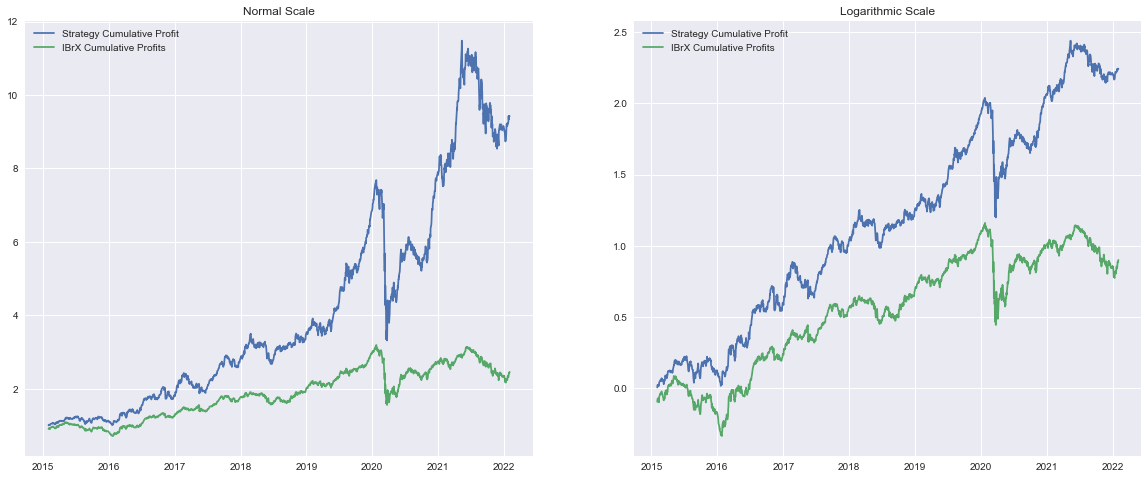

In [9]:
strategy.plot_results()

+------------------------+------------+-------------+
|                        | Strategy   | Benchmark   |
+========================+============+=============+
| Start Period           | 2015-02-02 | 2015-02-02  |
+------------------------+------------+-------------+
| End Period             | 2022-01-31 | 2022-01-31  |
+------------------------+------------+-------------+
| Cumulative Return      | 897.68%    | 212.93%     |
+------------------------+------------+-------------+
| CAGR %                 | 38.90%     | 17.70%      |
+------------------------+------------+-------------+
| Sharpe Ratio           | 1.239      | 0.768       |
+------------------------+------------+-------------+
| Prob. Sharpe Ratio     | 62.38%     | 19.35%      |
+------------------------+------------+-------------+
| Information Ratio      | 0.075      | 0.075       |
+------------------------+------------+-------------+
| Calmar Ratio           | 0.64       | 0.34        |
+------------------------+--

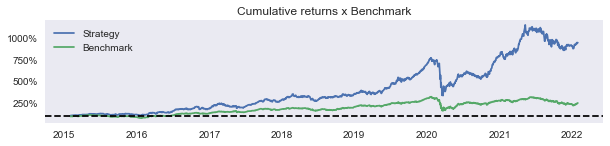

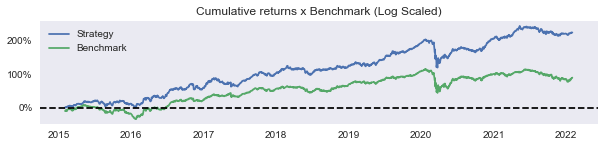

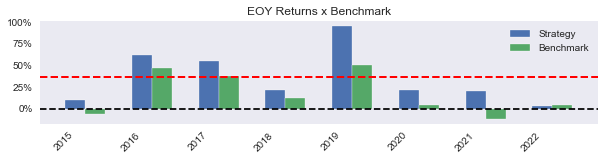

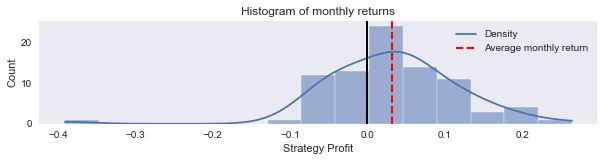

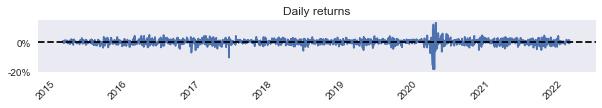

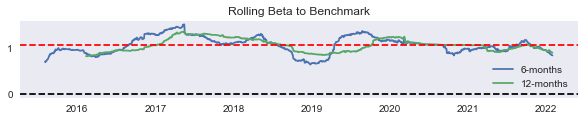

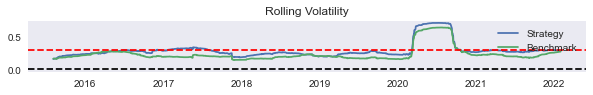

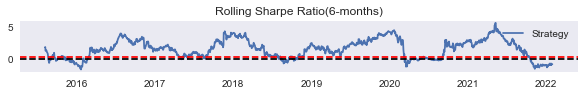

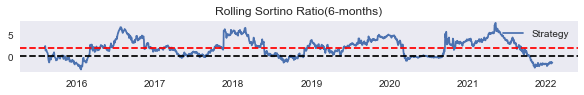

In [10]:
strategy.returns_analysis()